In [1]:
# clone YOLOv5 and reset to a specific git checkpoint that has been verified working
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (Tesla P100-PCIE-16GB)


In [2]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)


     |████████████████████████████████| 636 kB 8.1 MB/s 


In [3]:
# install dependencies as necessary
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [4]:
# Export code snippet and paste here
%cd /content
!curl -L "https://app.roboflow.com/ds/fNrlUD68D7?key=Sc5CneibAs" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1343      0 --:--:-- --:--:-- --:--:--  1341
100  133M  100  133M    0     0  78.8M      0  0:00:01  0:00:01 --:--:--  211M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/road110_png.rf.1fd6f6619fe1231294c6a4c600dc4205.jpg  
 extracting: test/images/road111_png.rf.199f8482151e6b646477927e10cb43f3.jpg  
 extracting: test/images/road113_png.rf.2dccedff557e9a2fd396f0aa45c25284.jpg  
 extracting: test/images/road115_png.rf.6fa12b46910e725f8e73f6194ddbddc6.jpg  
 extracting: test/images/road118_png.rf.63bc570522702ccdc8a69d0101929af8.jpg  
 extracting: test/images/road124_png.rf.e1336441ddeeff4393fa687bf76e204a.jpg  
 extracting: test/images/road134_png.rf.0a7cfabf2850d5007

In [5]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 4
names: ['crosswalk', 'speedlimit', 'stop', 'trafficlight']

In [6]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [8]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 4  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [9]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 4 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=4, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-383-g8b18b66 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4

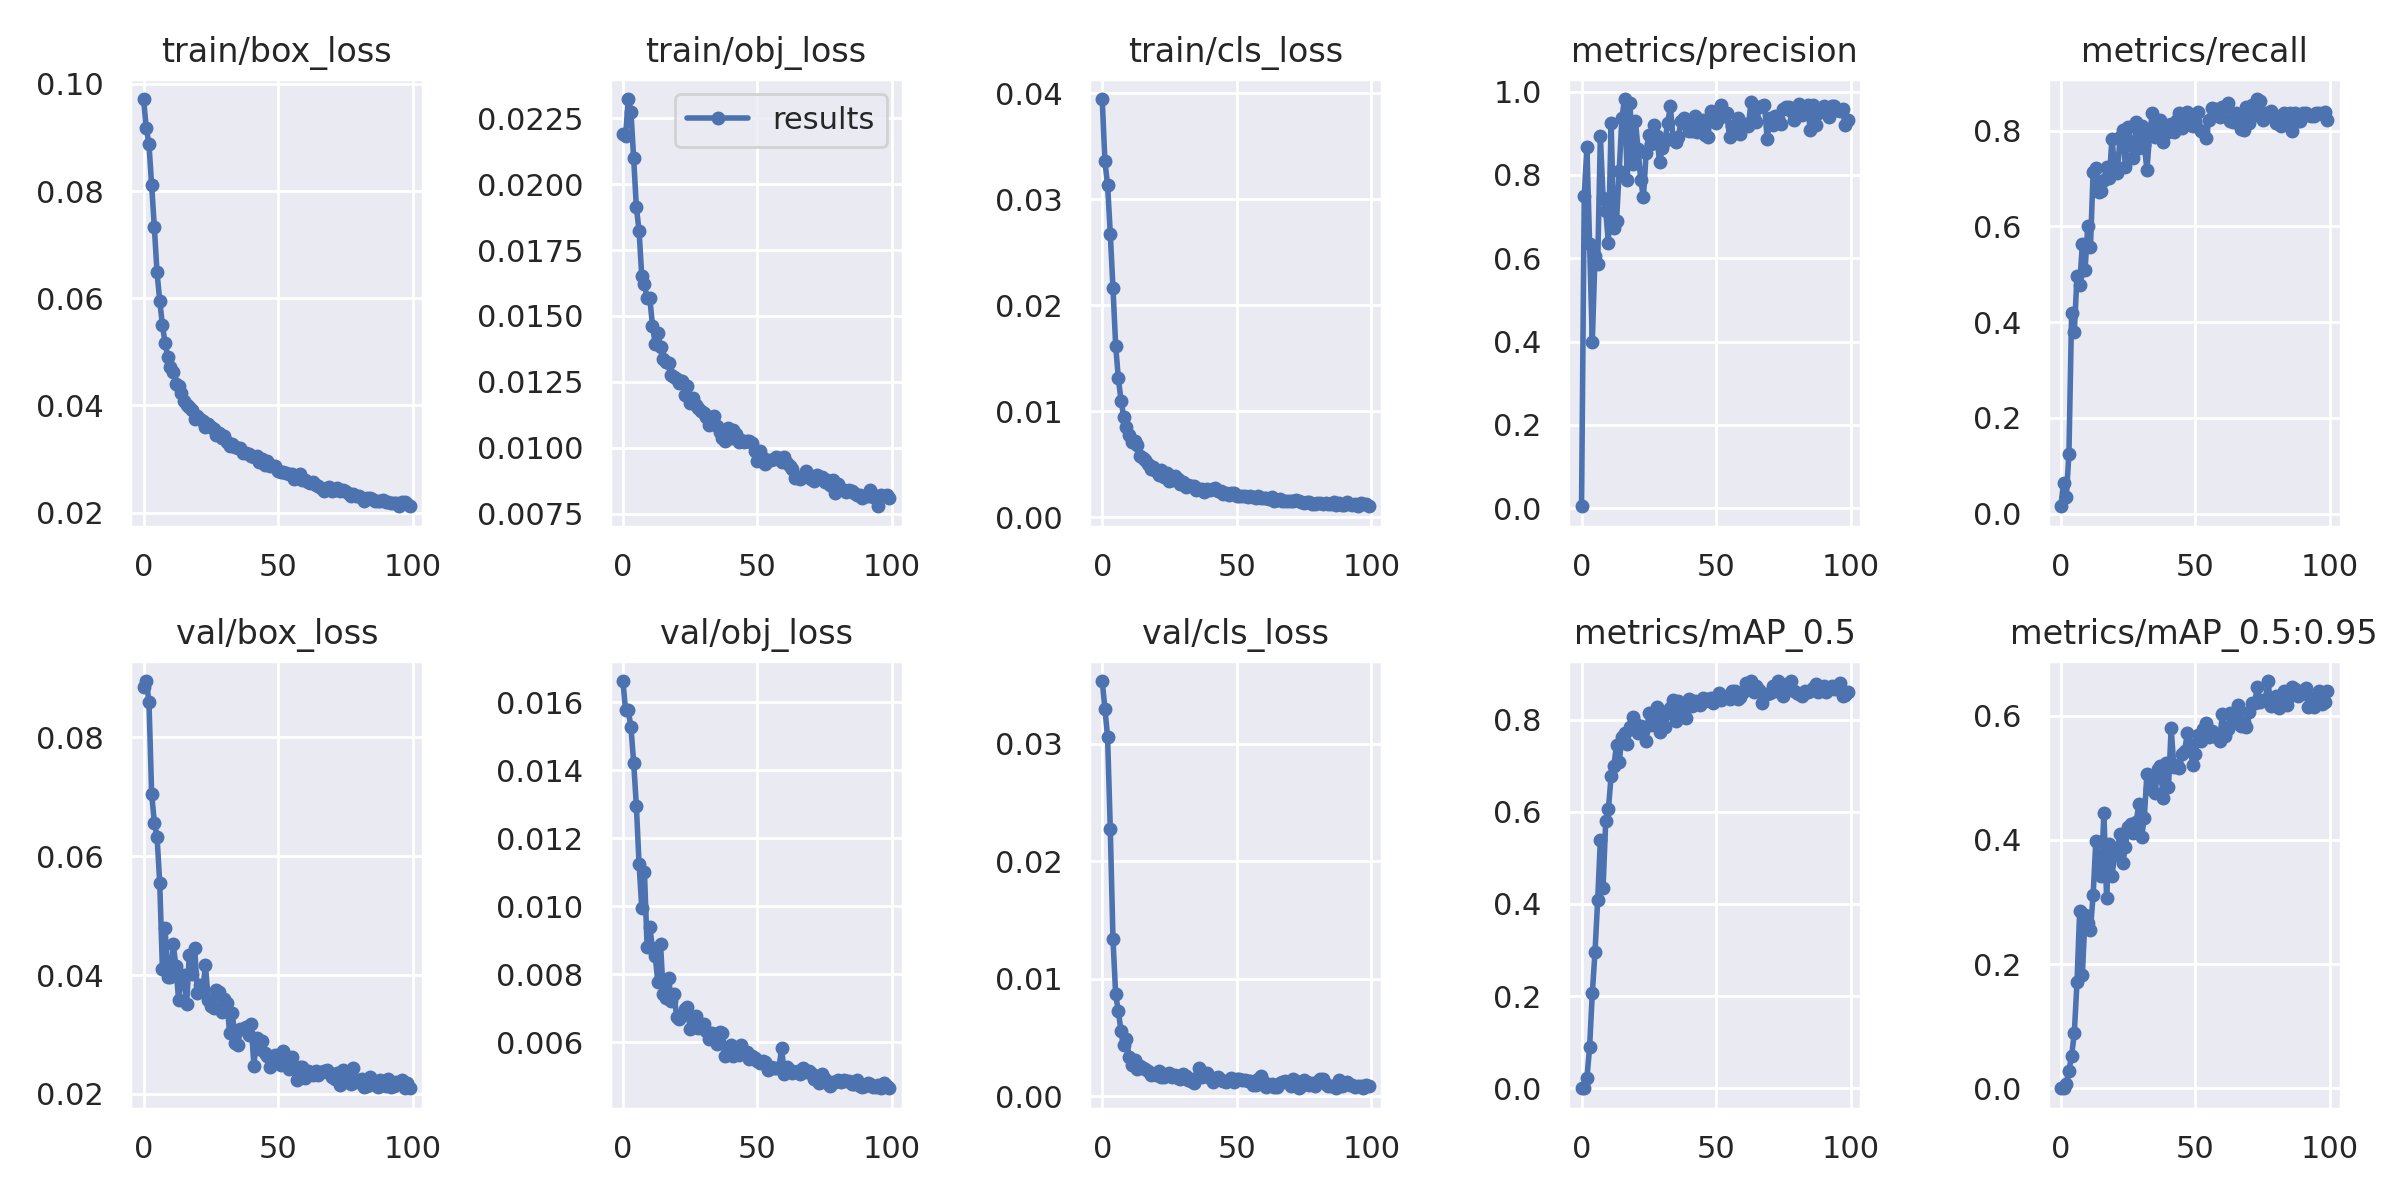

In [10]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


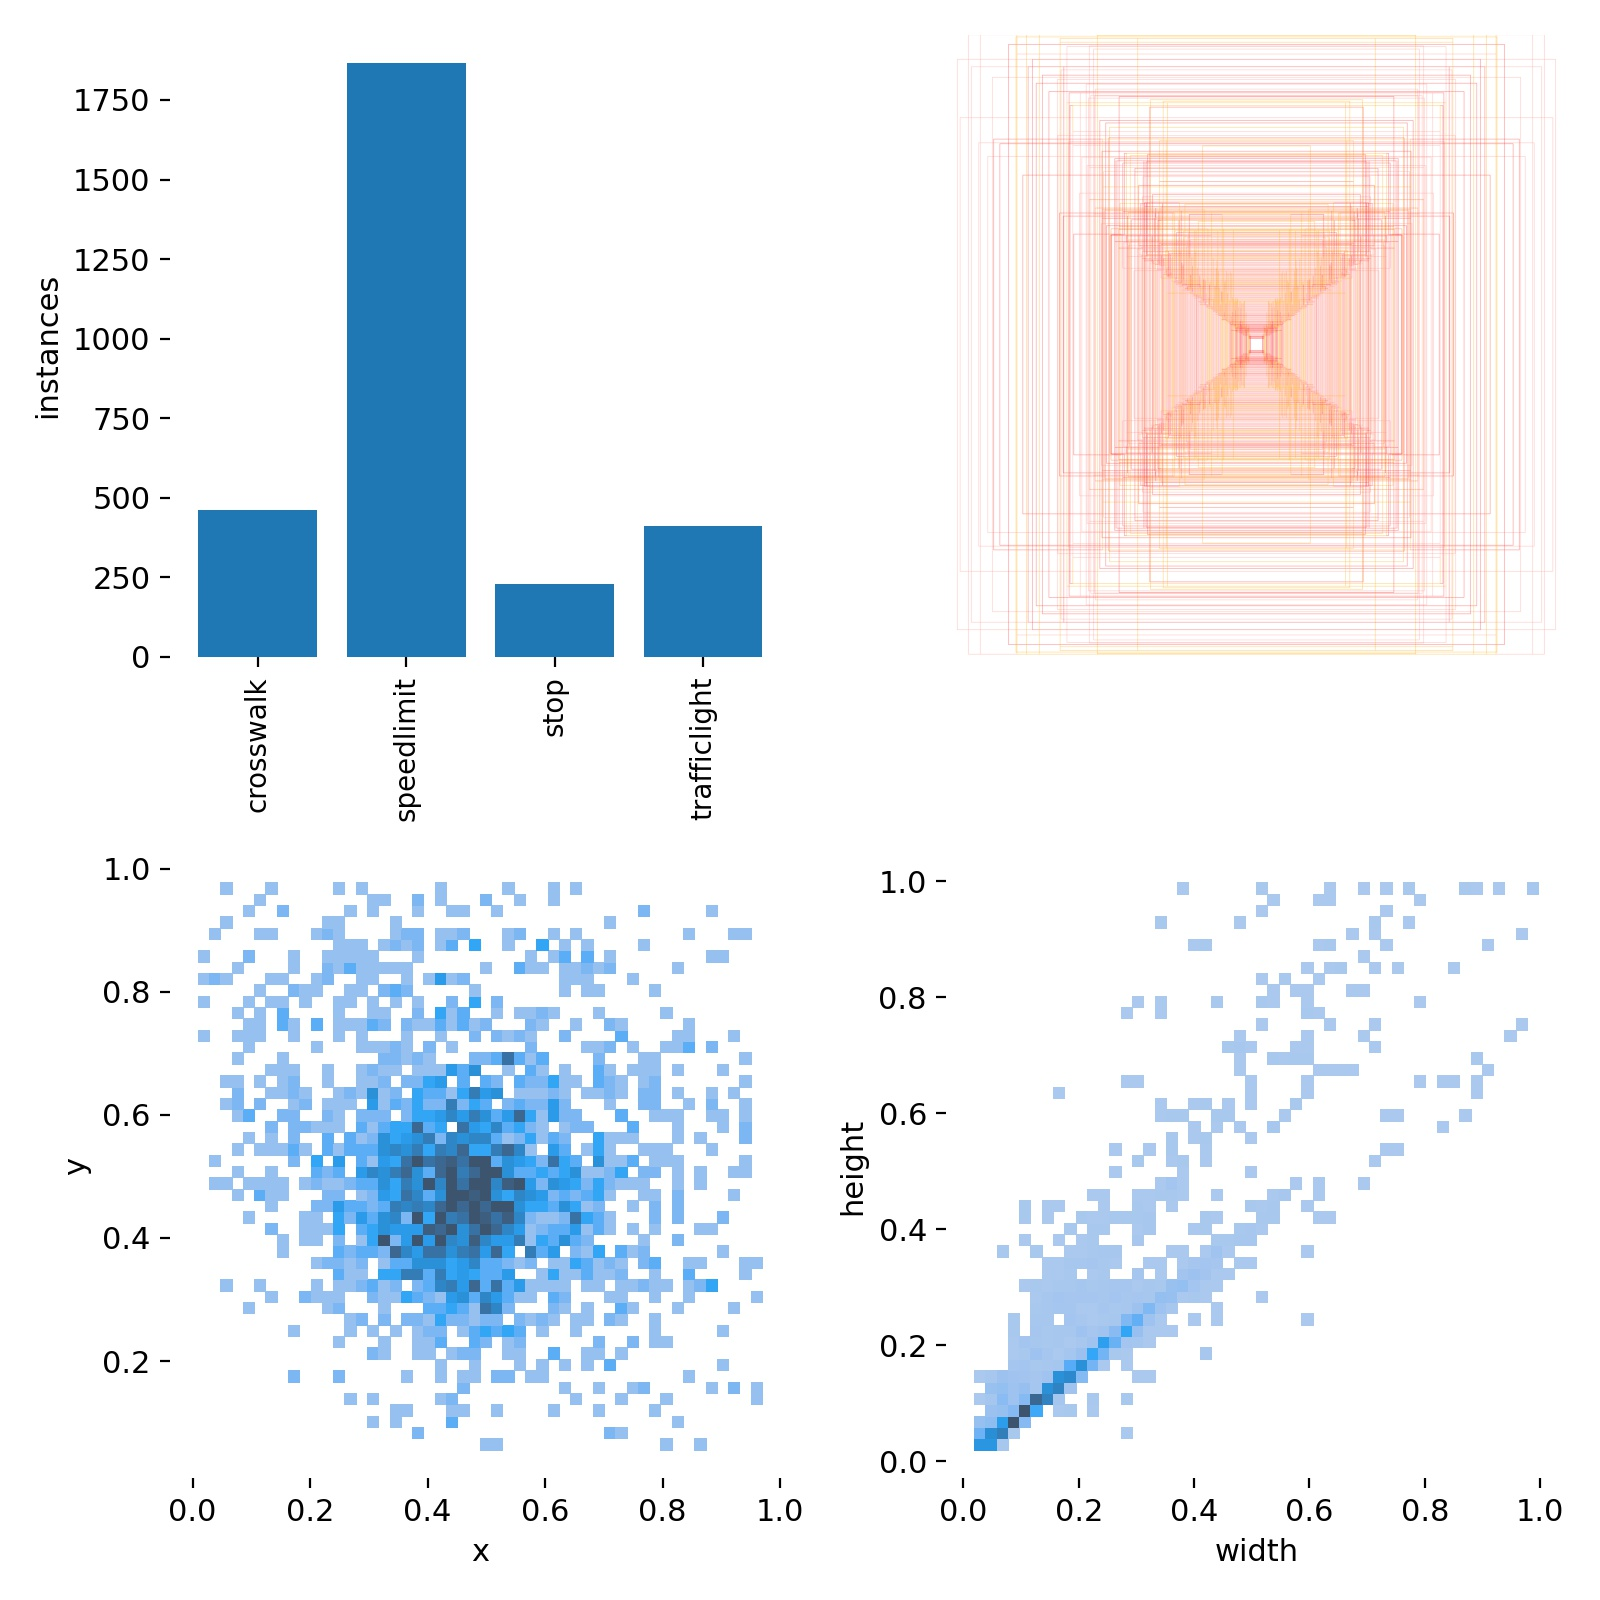

In [12]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


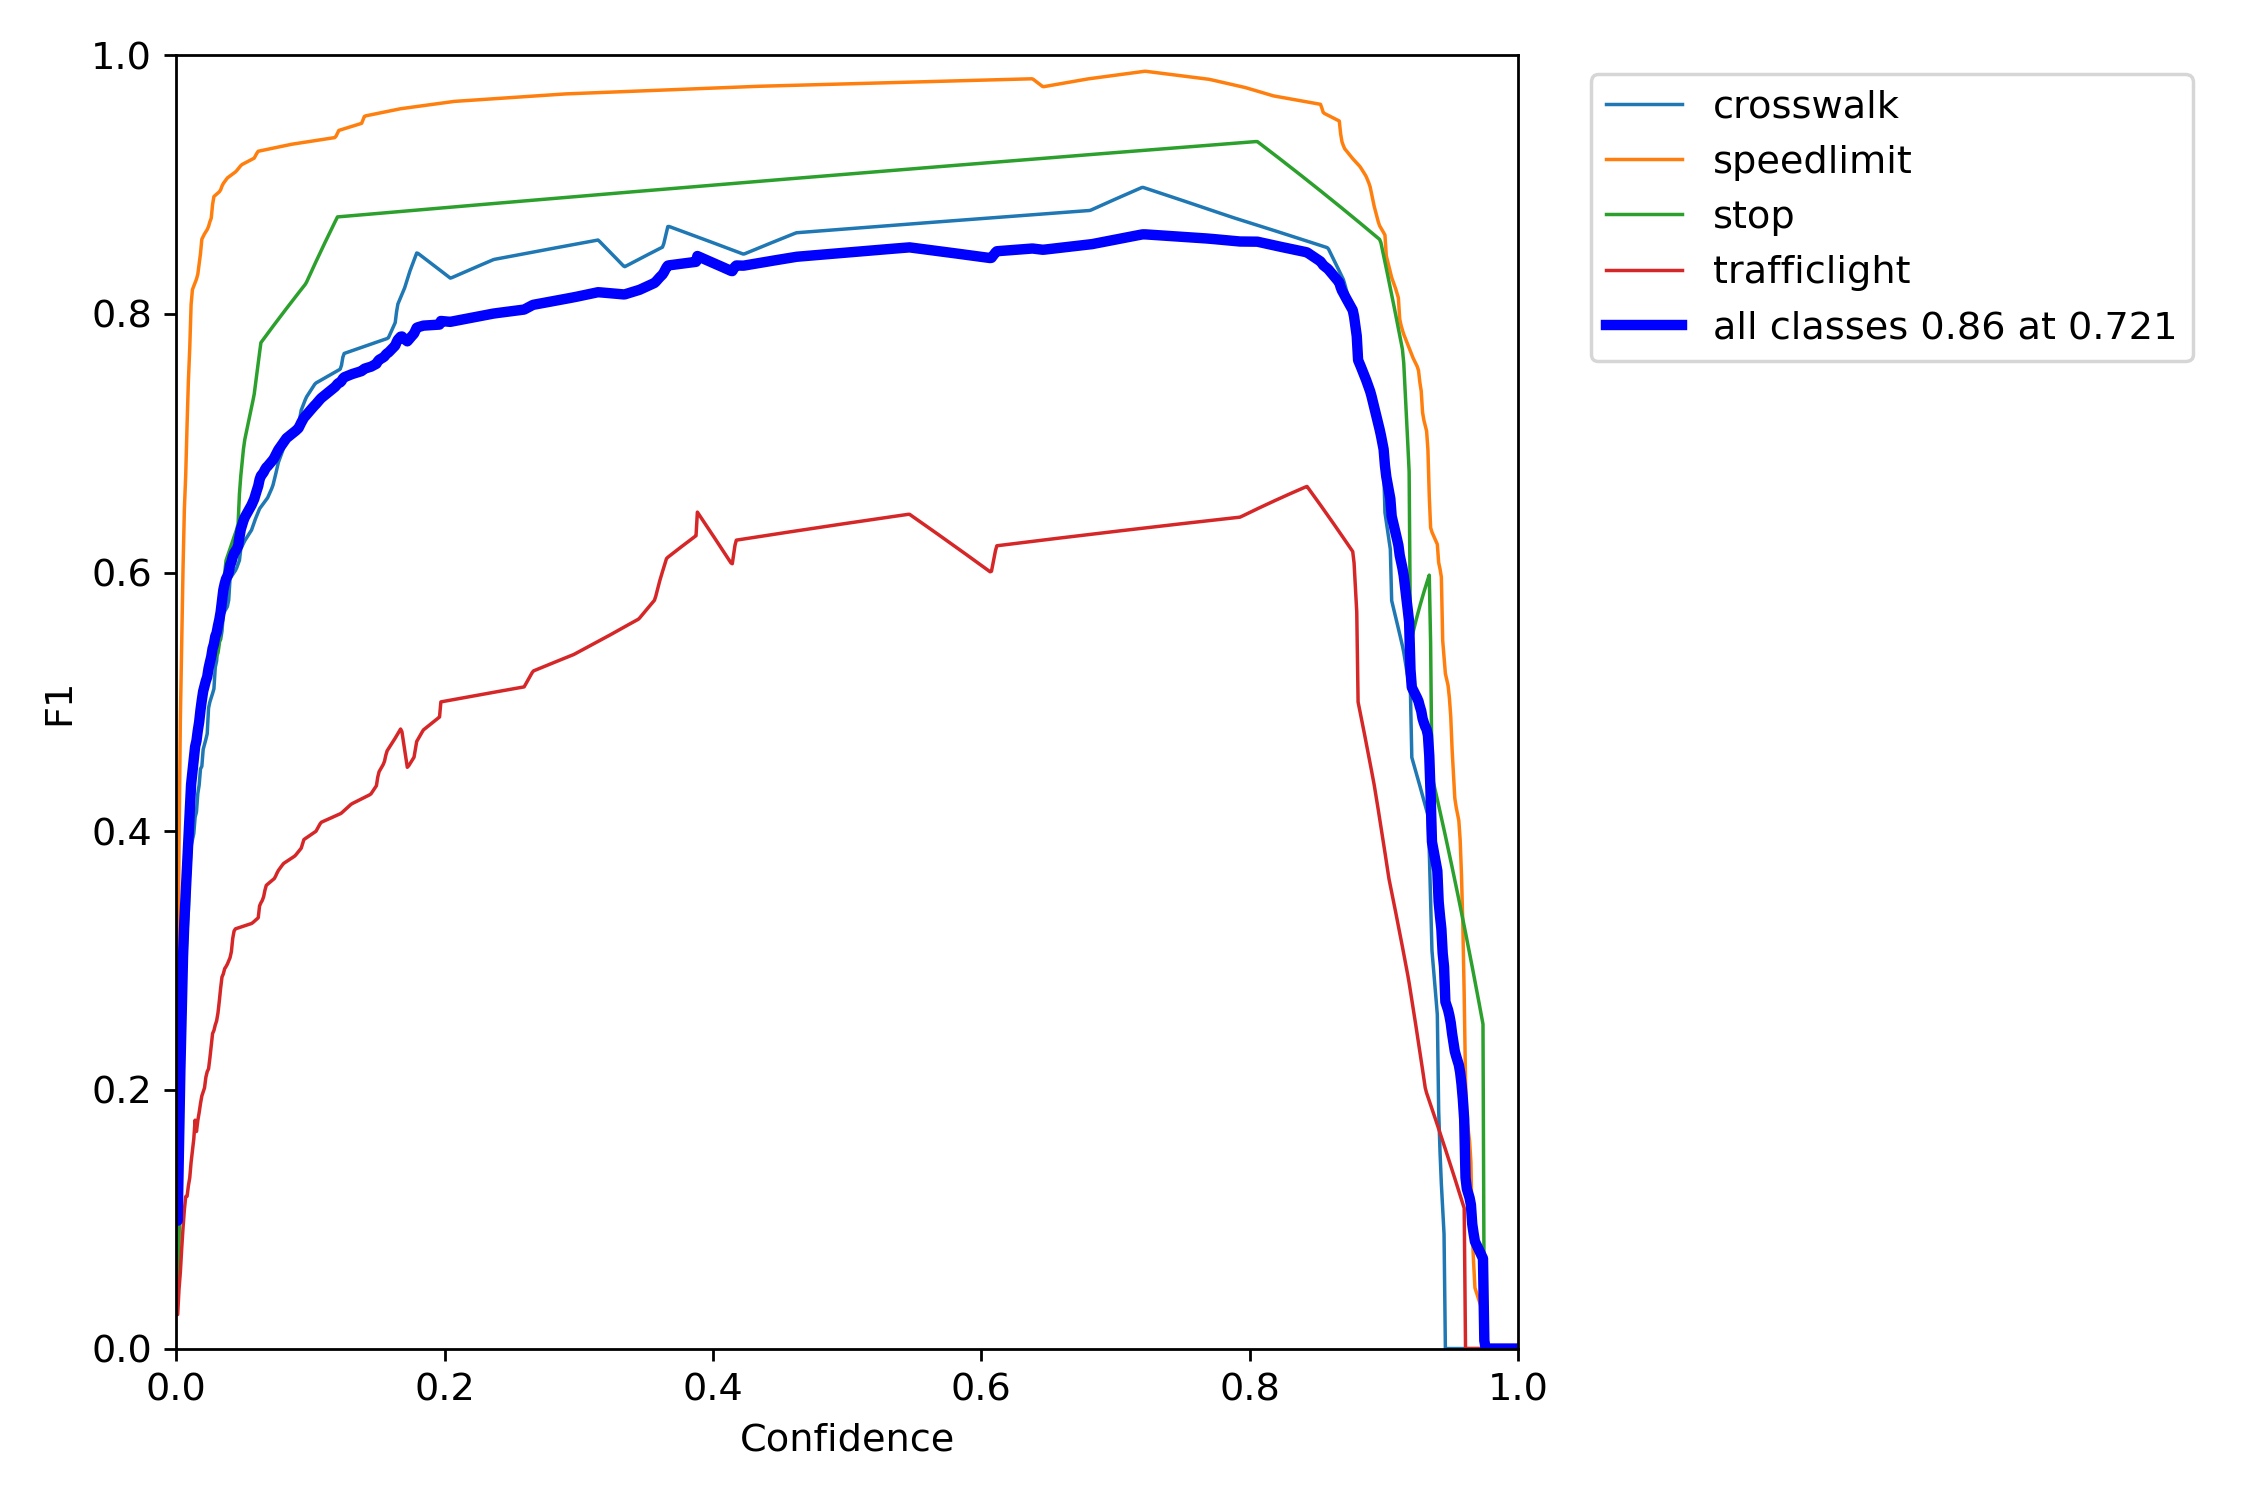

In [14]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/F1_curve.png', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


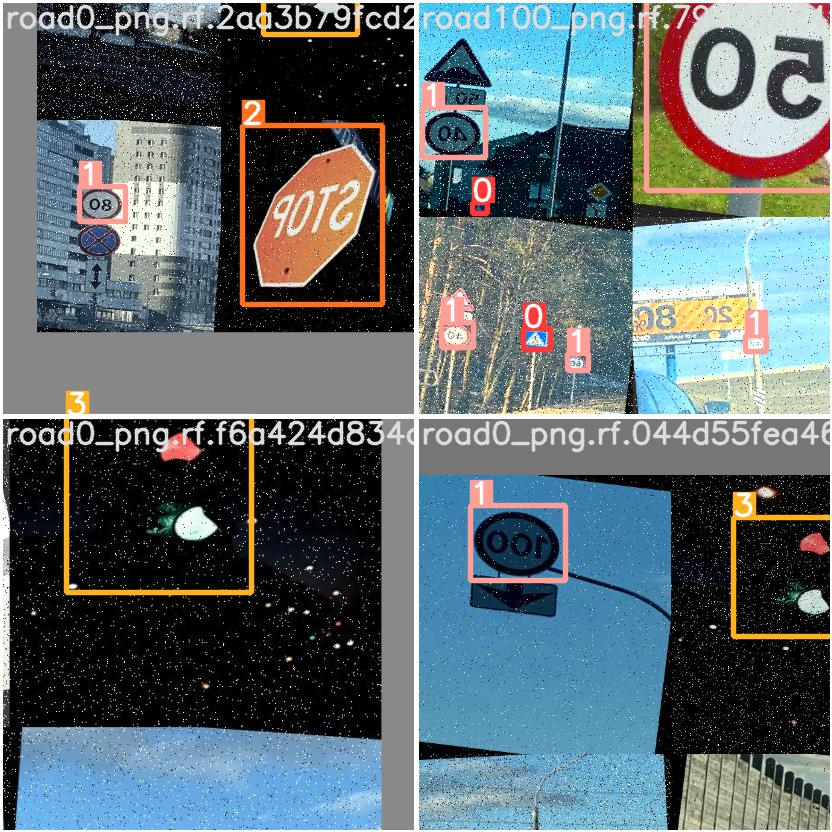

In [13]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [15]:
!pip install onnx

     |████████████████████████████████| 12.3 MB 7.6 MB/s 


In [18]:
%cd /content/yolov5
!python export.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --batch 1

/content/yolov5
export: weights=/content/yolov5/runs/train/yolov5s_results/weights/best.pt, img_size=[416], batch_size=1, device=cpu, include=['torchscript', 'onnx', 'coreml'], half=False, inplace=False, train=False, optimize=False, dynamic=False, simplify=False, opset=13
YOLOv5 🚀 v5.0-383-g8b18b66 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/yolov5s_results/weights/best.pt (14.4 MB)

TorchScript: starting export with torch 1.9.0+cu102...
/content/yolov5/models/yolo.py:58: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4] or self.onnx_dynamic:
/content/yolov5/models/yolo.py:58: TracerWarning: Converting a tenso